<a href="https://colab.research.google.com/github/praseedm/tracin_implemention_on_ledgar_dataset/blob/main/Find_opponent_%26_proponents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# clone git repo for data
! git clone https://github.com/praseedm/tracin_implemention_on_ledgar_dataset.git

Cloning into 'tracin_implemention_on_ledgar_dataset'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 48 (delta 19), reused 17 (delta 5), pack-reused 0
Unpacking objects: 100% (48/48), done.


In [2]:
# Mount GDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd tracin_implemention_on_ledgar_dataset

/content/tracin_implemention_on_ledgar_dataset


In [4]:
# copying checkpoints 
!cp -r /content/drive/MyDrive/ARU/ML\ Project/train_outputs ./

In [5]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 5.4 MB/s 
     |████████████████████████████████| 462 kB 46.7 MB/s 


In [6]:
import os

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow_text as text
import pandas as pd
import json


tf.get_logger().setLevel('ERROR')

In [7]:
!nvidia-smi

Tue Apr 26 20:50:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
tf.__version__

'2.8.0'

## Data Preparation

In [9]:
BATCH_SIZE = 32
SEED = 10
AUTOTUNE = tf.data.AUTOTUNE

In [10]:
def generate_batch_dataset_from_csv(csv_path:str):
  df = pd.read_csv(csv_path)
  dataset = tf.data.Dataset.from_tensor_slices(
      (
          df['text'].values,
          df['label'].values
      )
  )
  print(f"{len(dataset)}\n{dataset.element_spec}")
  return dataset.batch(batch_size=BATCH_SIZE)

In [11]:
train_ds = generate_batch_dataset_from_csv(csv_path='./data/train_data.csv')
test_ds = generate_batch_dataset_from_csv(csv_path='./data/test_data.csv')

32906
(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
5438
(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [12]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
# Load labels 
with open('./data/label_names.json') as rb:
  label_names = json.load(rb)
print(f"Loaded {len(label_names)} labels")
print(f"Labels : {label_names}")

Loaded 25 labels
Labels : ['Amendments', 'Assignments', 'Compliance With Laws', 'Confidentiality', 'Counterparts', 'Entire Agreements', 'Expenses', 'Financial Statements', 'Further Assurances', 'General', 'Governing Laws', 'Indemnifications', 'Insurances', 'Litigations', 'No Conflicts', 'Notices', 'Payments', 'Severability', 'Survival', 'Taxes', 'Terminations', 'Terms', 'Use Of Proceeds', 'Waiver Of Jury Trials', 'Waivers']


## Classifier Model

In [15]:
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'

In [16]:
def build_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='input')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='BERT_preprocessing')
  preprocessed_text = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(preprocessed_text)
  x = outputs['pooled_output']
  x = tf.keras.layers.Dropout(0.1)(x)
  x = tf.keras.layers.Dense(len(label_names), activation=None, name='output')(x)
  return tf.keras.Model(text_input, x)

In [17]:
model = build_model()

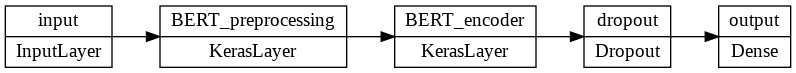

In [18]:
tf.keras.utils.plot_model(model, rankdir='LR')